# Importing Libraries

In [ ]:
import os
import dlib
import collections
from typing import Union, List
import numpy as np
from PIL import Image
import PIL.Image
import PIL.ImageFile
import scipy.ndimage
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numpy.lib.type_check import imag
import torch
from torch import nn
import torch.nn.functional as F
from skimage.feature import hog

# Original Image

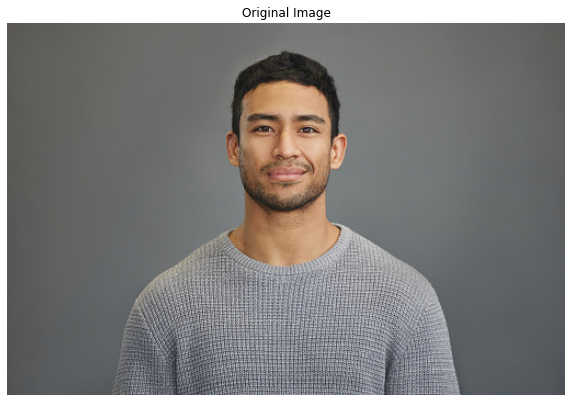

In [ ]:
img_original = cv2.imread('/content/face.jpg')

img = cv2.cvtColor(img_original,cv2.COLOR_BGR2RGB)
img_original = img
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

# Initial Work

Filtering

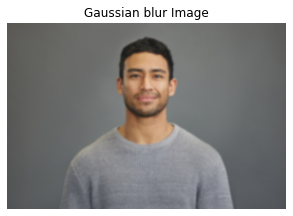

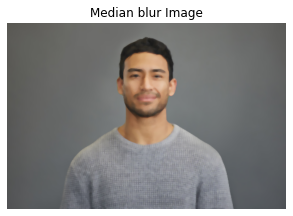

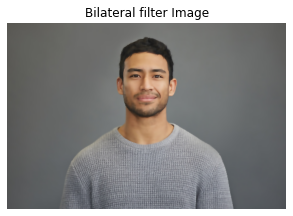

In [ ]:
# Apply some Gaussian blur on the image
img_gb = cv2.GaussianBlur(img, (7, 7) ,0)
plt.figure(figsize=(5, 5))
plt.imshow(img_gb)
plt.axis("off")
plt.title("Gaussian blur Image")
plt.show()

# Apply some Median blur on the image
img_mb = cv2.medianBlur(img, 5)
plt.figure(figsize=(5, 5))
plt.imshow(img_mb)
plt.axis("off")
plt.title("Median blur Image")
plt.show()

# Apply a bilateral filer on the image
img_bf = cv2.bilateralFilter(img, 5, 80, 80)
plt.figure(figsize=(5, 5))
plt.imshow(img_bf)
plt.axis("off")
plt.title("Bilateral filter Image")
plt.show()

Edge Detection

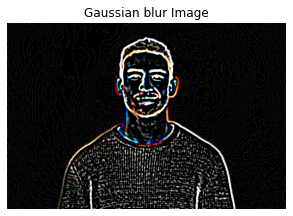

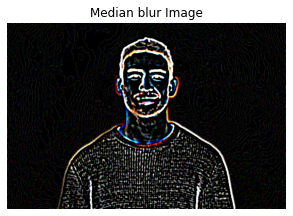

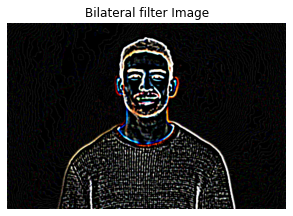

In [ ]:
# Apply some Gaussian blur on the image
imgg_lp = cv2.Laplacian(img_gb, cv2.CV_8U, ksize=5)
plt.figure(figsize=(5, 5))
plt.imshow(imgg_lp)
plt.axis("off")
plt.title("Gaussian blur Image")
plt.show()

# Apply some Median blur on the image
imgm_lp = cv2.Laplacian(img_gb, cv2.CV_8U, ksize=5)
plt.figure(figsize=(5, 5))
plt.imshow(imgm_lp)
plt.axis("off")
plt.title("Median blur Image")
plt.show()

# Apply a bilateral filer on the image
imgb_lp = cv2.Laplacian(img_gb, cv2.CV_8U, ksize=5)
plt.figure(figsize=(5, 5))
plt.imshow(imgb_lp)
plt.axis("off")
plt.title("Bilateral filter Image")
plt.show()


Final Output

(-0.5, 508.5, 338.5, -0.5)

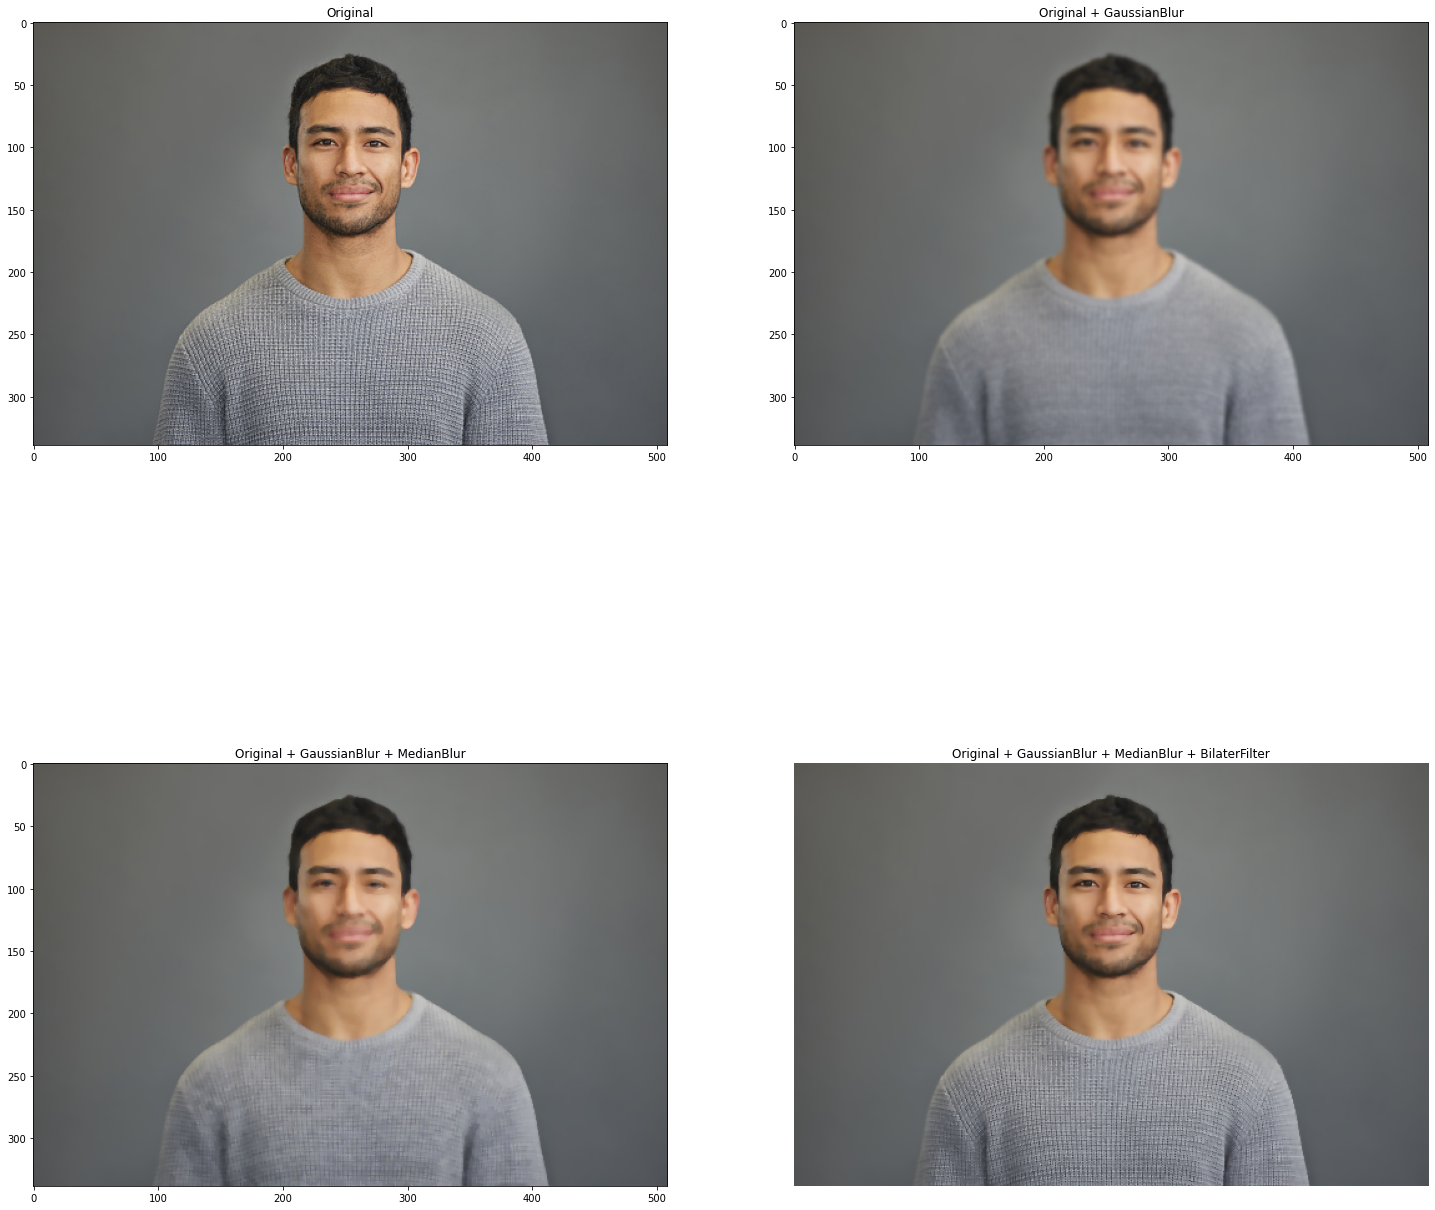

In [ ]:
# Plot the image to see some differences.
f, axarr = plt.subplots(2, 2, figsize=(25, 25))
axarr[0,0].imshow(img_original)
axarr[0,0].title.set_text('Original')
plt.axis('off')
axarr[0,1].imshow(img_gb)
axarr[0,1].title.set_text('Original + GaussianBlur')
plt.axis('off')
axarr[1,0].imshow(img_mb)
axarr[1,0].title.set_text('Original + GaussianBlur + MedianBlur')
plt.axis('off')
axarr[1,1].imshow(img_bf)
axarr[1,1].title.set_text('Original + GaussianBlur + MedianBlur + BilaterFilter')
plt.axis('off')


# DLIB Model

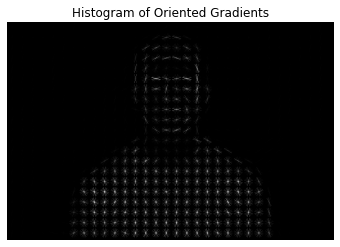

In [ ]:
img = cv2.cvtColor(img_original,cv2.COLOR_RGB2GRAY)
fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True)
plt.axis('off')
plt.imshow(hog_image, cmap=plt.cm.gray)
plt.title('Histogram of Oriented Gradients')
plt.show()

Build HOG and SVM LINEAR Model 

In [ ]:
def get_dlib_face_detector():

    detector = dlib.get_frontal_face_detector()
    shape_predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")

    def detect_face_landmarks(img: Union[Image.Image, np.ndarray]):
        if isinstance(img, Image.Image):
            img = np.array(img)
        faces = []
        dets = detector(img)
        for d in dets:
            shape = shape_predictor(img, d)
            faces.append(np.array([[v.x, v.y] for v in shape.parts()]))
        return faces
    return detect_face_landmarks


In [ ]:
def display_facial_landmarks(img: Image,landmarks: List[np.ndarray]):
    plot_style = dict(marker='o',markersize=4,linestyle='-',lw=2)
    pred_type = collections.namedtuple('prediction_type', ['slice', 'color'])
    pred_types = {
        'face': pred_type(slice(0, 17), (0.682, 0.780, 0.909, 0.5)),
        'eyebrow1': pred_type(slice(17, 22), (1.0, 0.498, 0.055, 0.4)),
        'eyebrow2': pred_type(slice(22, 27), (1.0, 0.498, 0.055, 0.4)),
        'nose': pred_type(slice(27, 31), (0.345, 0.239, 0.443, 0.4)),
        'nostril': pred_type(slice(31, 36), (0.345, 0.239, 0.443, 0.4)),
        'eye1': pred_type(slice(36, 42), (0.596, 0.875, 0.541, 0.3)),
        'eye2': pred_type(slice(42, 48), (0.596, 0.875, 0.541, 0.3)),
        'lips': pred_type(slice(48, 60), (0.596, 0.875, 0.541, 0.3)),
        'teeth': pred_type(slice(60, 68), (0.596, 0.875, 0.541, 0.4))
    }

    plt.imshow(img)
    plt.axis('off')
    for face in landmarks:
        for pred_type in pred_types.values():
            plt.plot(face[pred_type.slice, 0],face[pred_type.slice, 1],
                color=pred_type.color, **plot_style)
    plt.show()

In [ ]:
def align_and_crop_face(
    img: Image.Image,
    landmarks: np.ndarray,
    expand: float = 1.0,
    output_size: int = 1024, 
    transform_size: int = 4096,
    enable_padding: bool = True,
):
    # Parse landmarks.
    # pylint: disable=unused-variable
    lm = landmarks
    lm_chin          = lm[0  : 17]  # left-right
    lm_eyebrow_left  = lm[17 : 22]  # left-right
    lm_eyebrow_right = lm[22 : 27]  # left-right
    lm_nose          = lm[27 : 31]  # top-down
    lm_nostrils      = lm[31 : 36]  # top-down
    lm_eye_left      = lm[36 : 42]  # left-clockwise
    lm_eye_right     = lm[42 : 48]  # left-clockwise
    lm_mouth_outer   = lm[48 : 60]  # left-clockwise
    lm_mouth_inner   = lm[60 : 68]  # left-clockwise

    # Calculate auxiliary vectors.
    eye_left     = np.mean(lm_eye_left, axis=0) 
    eye_right    = np.mean(lm_eye_right, axis=0)
    eye_avg      = (eye_left + eye_right) * 0.5
    eye_to_eye   = eye_right - eye_left
    mouth_left   = lm_mouth_outer[0]
    mouth_right  = lm_mouth_outer[6]
    mouth_avg    = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)
    x *= max(np.hypot(*eye_to_eye) * 2.0, np.hypot(*eye_to_mouth) * 1.8)
    x *= expand
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.1
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    qsize = np.hypot(*x) * 2

    # Shrink.
    shrink = int(np.floor(qsize / output_size * 0.5))
    if shrink > 1:
        rsize = (int(np.rint(float(img.size[0]) / shrink)), int(np.rint(float(img.size[1]) / shrink)))
        img = img.resize(rsize, PIL.Image.ANTIALIAS)
        quad /= shrink
        qsize /= shrink
    border = max(int(np.rint(qsize * 0.1)), 3)
  
    # Crop.
    crop = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    crop = (max(crop[0] - border, 0), max(crop[1] - border, 0), min(crop[2] + border, img.size[0]), min(crop[3] + border, img.size[1]))
    if crop[2] - crop[0] < img.size[0] or crop[3] - crop[1] < img.size[1]:
        img = img.crop(crop)
        quad -= crop[0:2]
    # Pad.
    pad = (int(np.floor(min(quad[:,0]))), int(np.floor(min(quad[:,1]))), int(np.ceil(max(quad[:,0]))), int(np.ceil(max(quad[:,1]))))
    pad = (max(-pad[0] + border, 0), max(-pad[1] + border, 0), max(pad[2] - img.size[0] + border, 0), max(pad[3] - img.size[1] + border, 0))
    if enable_padding and max(pad) > border - 4:
        pad = np.maximum(pad, int(np.rint(qsize * 0.3)))
        img = np.pad(np.float32(img), ((pad[1], pad[3]), (pad[0], pad[2]), (0, 0)), 'reflect')
        h, w, _ = img.shape
        y, x, _ = np.ogrid[:h, :w, :1]
        mask = np.maximum(1.0 - np.minimum(np.float32(x) / pad[0], np.float32(w-1-x) / pad[2]), 1.0 - np.minimum(np.float32(y) / pad[1], np.float32(h-1-y) / pad[3]))
        blur = qsize * 0.02
        img += (scipy.ndimage.gaussian_filter(img, [blur, blur, 0]) - img) * np.clip(mask * 3.0 + 1.0, 0.0, 1.0)
        img += (np.median(img, axis=(0,1)) - img) * np.clip(mask, 0.0, 1.0)
        img = PIL.Image.fromarray(np.uint8(np.clip(np.rint(img), 0, 255)), 'RGB')
        quad += pad[:2]

    # Transform.
    img = img.transform((transform_size, transform_size), PIL.Image.QUAD, (quad + 0.5).flatten(), PIL.Image.BILINEAR)
    if output_size < transform_size:
        img = img.resize((output_size, output_size), PIL.Image.ANTIALIAS)
    return img


#PyTorch Model

In [ ]:
class ConvNormLReLU(nn.Sequential):
    def __init__(self, in_ch, out_ch, kernel_size=3, stride=1, padding=1, pad_mode="reflect", groups=1, bias=False):
        pad_layer = {
            "zero":    nn.ZeroPad2d,
            "same":    nn.ReplicationPad2d,
            "reflect": nn.ReflectionPad2d,
        }
        if pad_mode not in pad_layer:
            raise NotImplementedError
        super(ConvNormLReLU, self).__init__(
            pad_layer[pad_mode](padding),
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding=0, groups=groups, bias=bias),
            nn.GroupNorm(num_groups=1, num_channels=out_ch, affine=True),
            nn.LeakyReLU(0.2, inplace=True)
        )


class InvertedResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, expansion_ratio=2):
        super(InvertedResBlock, self).__init__()

        self.use_res_connect = in_ch == out_ch
        bottleneck = int(round(in_ch*expansion_ratio))
        layers = []
        if expansion_ratio != 1:
            layers.append((in_ch, bottleneck, kernel_size=1, padding=0))
        
        # dw
        layers.append(ConvNormLReLU(bottleneck, bottleneck, groups=bottleneck, bias=True))
        # pw
        layers.append(nn.Conv2d(bottleneck, out_ch, kernel_size=1, padding=0, bias=False))
        layers.append(nn.GroupNorm(num_groups=1, num_channels=out_ch, affine=True))

        self.layers = nn.Sequential(*layers)
        
    def forward(self, input):
        out = self.layers(input)
        if self.use_res_connect:
            out = input + out
        return out

    
class Generator(nn.Module):
    def __init__(self, ):
        super().__init__()
        
        self.block_a = nn.Sequential(
            ConvNormLReLU(3,  32, kernel_size=7, padding=3),
            ConvNormLReLU(32, 64, stride=2, padding=(0,1,0,1)),
            ConvNormLReLU(64, 64)
        )
        
        self.block_b = nn.Sequential(
            ConvNormLReLU(64,  128, stride=2, padding=(0,1,0,1)),            
            ConvNormLReLU(128, 128)
        )
        
        self.block_c = nn.Sequential(
            ConvNormLReLU(128, 128),
            InvertedResBlock(128, 256, 2),
            InvertedResBlock(256, 256, 2),
            InvertedResBlock(256, 256, 2),
            InvertedResBlock(256, 256, 2),
            ConvNormLReLU(256, 128),
        )    
        
        self.block_d = nn.Sequential(
            ConvNormLReLU(128, 128),
            ConvNormLReLU(128, 128)
        )

        self.block_e = nn.Sequential(
            ConvNormLReLU(128, 64),
            ConvNormLReLU(64,  64),
            ConvNormLReLU(64,  32, kernel_size=7, padding=3)
        )

        self.out_layer = nn.Sequential(
            nn.Conv2d(32, 3, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Tanh()
        )
        
    def forward(self, input, align_corners=True):
        out = self.block_a(input)
        half_size = out.size()[-2:]
        out = self.block_b(out)
        out = self.block_c(out)
        
        if align_corners:
            out = F.interpolate(out, half_size, mode="bilinear", align_corners=True)
        else:
            out = F.interpolate(out, scale_factor=2, mode="bilinear", align_corners=False)
        out = self.block_d(out)

        if align_corners:
            out = F.interpolate(out, input.size()[-2:], mode="bilinear", align_corners=True)
        else:
            out = F.interpolate(out, scale_factor=2, mode="bilinear", align_corners=False)
        out = self.block_e(out)

        out = self.out_layer(out)
        return out

# Final Output

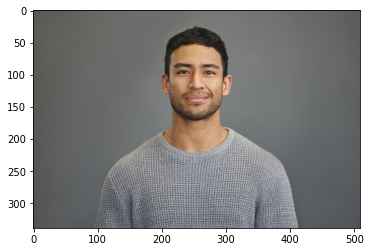

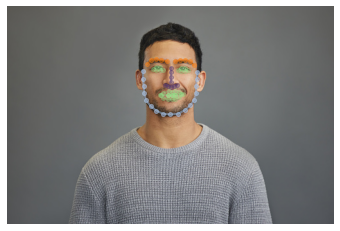

In [ ]:
img = Image.open("/content/face.jpg")
plt.imshow(img)
plt.show()
face_detector = get_dlib_face_detector()
landmarks = face_detector(img)
display_facial_landmarks(img, landmarks)


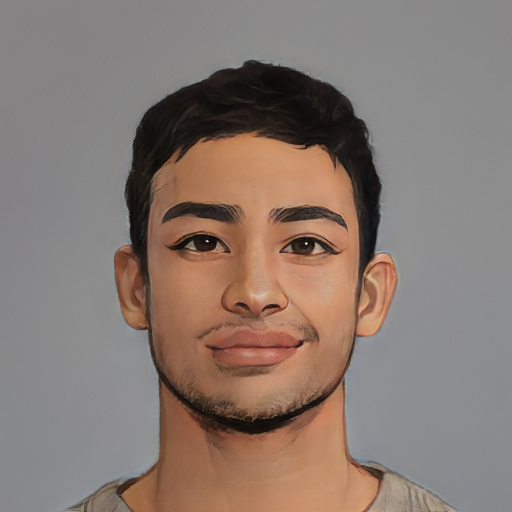

In [ ]:

for landmark in landmarks:
    face = align_and_crop_face(img, landmark, expand=1.3)
    display(face2paint(model=model, img=face, size=512))
imgt = face


# Accuracy Test

In [ ]:
diffs = []
imgt = np.array(imgt) 
for k, color in enumerate(("b", "r", "g")):
    real_histogram = cv2.calcHist(img_original, [k], None, [256], [0, 256])
    color_histogram = cv2.calcHist(imgt, [k], None, [256], [0, 256])
    diffs.append(cv2.compareHist(real_histogram, color_histogram, cv2.HISTCMP_CORREL))

<PIL.Image.Image image mode=RGB size=1024x1024 at 0x7F74800C3A60>


In [ ]:
d=sum(diffs)/3
print("the accuracy score of the model is:",d)

the accuracy score of the model is: 0.7920972090798596
